# Poisson Problem

In this notebook, we solve the Poisson equation using the finite element method.

In [1]:
from mpi4py import MPI
from dolfinx import mesh 
domain=mesh.create_unit_square(MPI.COMM_WORLD,8,8,mesh.CellType.quadrilateral)
# Thus I will have a total of 8x8=64 elements
# and 9x9=81 nodes on the mesh

In [2]:
from dolfinx.fem import functionspace
V=functionspace(domain,('Lagrange',1))

## Mesh Generation

We generate the mesh for the domain.

In [3]:
# Let's define the exact solution of my problem
from dolfinx import fem 
uD= fem.Function(V) # only used to initialize the function, and at the beginning uD will contain all zeros
uD.interpolate(lambda x: 1+x[0]**2 + 2*x[1]**2) # populates uD by interpolating the equation on the mesh nodes

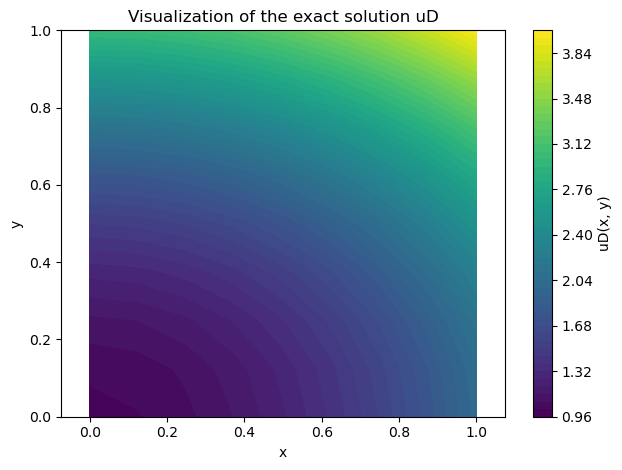

shape coords= (81, 3)
values coords= (81,)


In [4]:
import matplotlib.pyplot as plt 
import numpy as np 

# Display only on rank 0 (necessary with MPI)
if MPI.COMM_WORLD.rank == 0:
    # rank is the identifier number of the current process
    # since using MPI the program is executed simultaneously on
    # multiple processes, specifying process rank=0 ensures that
    # only this one will handle plotting!! This is to prevent all
    # parallel processes from trying to plot!!!!
    # Extract nodal coordinates and function values
    coords = domain.geometry.x # used to create an array containing the nodal coordinates of the mesh

    values = uD.x.array # creates a numpy array from uD
    X=coords[:, 0]  # extracts the x coordinates of all nodes
    Y=coords[:, 1]  # extracts the y coordinates of all nodes
    # Create scatter plot
    plt.tricontourf(X, Y, values, levels=50, cmap="viridis")
    plt.colorbar(label="uD(x, y)")
    plt.title("Visualization of the exact solution uD")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.axis("equal")
    plt.tight_layout()
    plt.show()

    print(f'shape coords= {coords.shape}')
    #print(coords)
    print(f'values coords= {values.shape}')

## Function Space

We define the function space for the solution.

## Boundary Conditions

We define the boundary conditions for the problem.

In [5]:
import numpy
# I want to determine the mesh facets that are on the boundary

tdim=domain.topology.dim  # topological dimension of the domain (e.g. 2 for 2D)
fdim=tdim-1 # dimension of the facets (for 2D mesh, facets are segments, so 1D);
# if we had a 3D mesh, the dimension of the facets would be 2D, as they would be "faces"

domain.topology.create_connectivity(fdim,tdim)
# Creates a MAPPING between facets and cells, necessary to know which facets belong to which cells.
# This information is not automatically computed in DOLFINx for efficiency.

boundary_facets=mesh.exterior_facet_indices(domain.topology)
# Identifies which facets are on the external boundary of the mesh, i.e., those adjacent to only one cell
# Returns an array with the indices of such facets.

print(f'Boundary facet indices are: {boundary_facets}')

Boundary facet indices are: [  0   1   3   5   9  13  17  23  27  35  39  49  53  65  69  83  86  87
 100 101 102 113 114 123 124 131 132 137 138 141 142 143]


In [6]:
print(tdim)

2


In [7]:
print(domain.topology) #

## Visualization of the Solution

We visualize the solution of the Poisson problem.

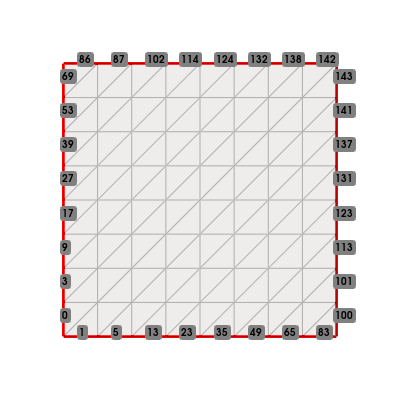

In [8]:
from dolfinx import plot
import pyvista

# Prepare the mesh for visualization
topology, cell_types, geometry = plot.vtk_mesh(domain, tdim)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

# Extract the mesh of the facets to visualize them
topo_facets, types_facets, geom_facets = plot.vtk_mesh(domain, fdim)
facet_grid = pyvista.UnstructuredGrid(topo_facets, types_facets, geom_facets)

# Add labels to the boundary edges (boundary facets)
labels = pyvista.PolyData()
labels.points = facet_grid.cell_centers().points[boundary_facets]
labels["indices"] = boundary_facets

# Visualization
plotter = pyvista.Plotter(window_size=(400,400))
plotter.add_mesh(grid, show_edges=True, color="white", opacity=0.3)
plotter.add_mesh(facet_grid.extract_cells(boundary_facets), color="red", line_width=3)
plotter.add_point_labels(labels, labels["indices"], font_size=10, text_color="black")
plotter.view_xy()
plotter.show()

In [9]:
# Now I define the BCs
# I now identify the indices of the dofs (where I will need to evaluate uD)
boundary_dofs=fem.locate_dofs_topological(V,fdim,boundary_facets)

# Now I can define the Dirichlet boundary conditions
bc=fem.dirichletbc(uD,boundary_dofs) 

## Error Calculation

We calculate the error of the numerical solution.

## Convergence Analysis

We analyze the convergence of the method.

In [10]:
import ufl 
u=ufl.TrialFunction(V)
v=ufl.TestFunction(V)

In [11]:
# Define the source term (which in my case is a constant f=-6)
from dolfinx import default_scalar_type
f=fem.Constant(domain,default_scalar_type(-6))

# This somewhat complex formulation to define f is useful in case we want
# to change the value of f (without having to redefine the variational problem from scratch)
# in fact, we would simply need to write: f.value= ..... 

## Analytical Solution

We compare the numerical solution with the analytical solution.

In [12]:
a=ufl.dot(ufl.grad(u),ufl.grad(v))*ufl.dx
L=f*v*ufl.dx
# Integration over the domain is ensured by the use of ufl.dx

In [13]:
from dolfinx.fem.petsc import LinearProblem

problem=LinearProblem(a,L,bcs=[bc],petsc_options={"ksp_type":"preonly","pc_type":"lu"})
uh=problem.solve()  # .solve() will return the solution of the linear problem as a dolfin.fem.Function

## Error Plot

We plot the error as a function of the mesh size.

In [14]:
# Define the vector space on which we want to interpolate uD
V2=fem.functionspace(domain,('Lagrange',2))
uex=fem.Function(V2) # initialize the vector
uex.interpolate(lambda x: 1 + x[0]**2 + 2*x[1]**2)

## Solution Plot

We plot the solution of the Poisson problem.

In [15]:
L2_error=fem.form(ufl.inner(uh-uex,uh-uex)*ufl.dx)
error_local=fem.assemble_scalar(L2_error) # used to compute the scalar value

error_L2=numpy.sqrt(domain.comm.allreduce(error_local,op=MPI.SUM)) # to take the square root of the scalar value
# and thus actually compute the L2-error

## Comparison with Analytical Solution

We compare the numerical and analytical solutions.

## Conclusions

We summarize the results obtained from the Poisson problem.

In [16]:
error_max=numpy.max(numpy.abs(uD.x.array-uh.x.array))
# I want to print the error with only 1 processor!!!
if domain.comm.rank==0:
    print(f'Error L2: {error_L2:.2e}')
    print(f'Error max: {error_max:.2e}')

Error L2: 8.24e-03
Error max: 5.33e-15


## Bibliography

References and bibliography for the Poisson problem.

In [17]:
import pyvista
print(pyvista.global_theme.jupyter_backend)

trame


In [18]:
from dolfinx import plot
# pyvista.start_xvfb()  # only needed if working in a Docker container
# Remember that tdim is the topological dimension of the domain (i.e. 2, since we have a 2D domain)

domain.topology.create_connectivity(tdim, tdim)
topology, cell_types, geometry = plot.vtk_mesh(domain, tdim) # vtk_mesh returns all the useful info
# to then build an unstructured grid with vtk and pyvista
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

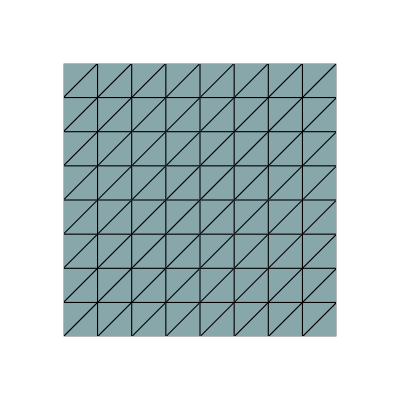

In [19]:
plotter = pyvista.Plotter(window_size=(400,400)) # creates the 2D and 3D rendering window
plotter.add_mesh(grid, show_edges=True) # adds the mesh to this window (and shows the edges of the various elements)
plotter.view_xy()
if not pyvista.OFF_SCREEN:
    plotter.show()  # to display the plot on screen
else:
    figure = plotter.screenshot("fundamentals_mesh.png")

Adesso vado a polttare la soluzione uh sulla mesh

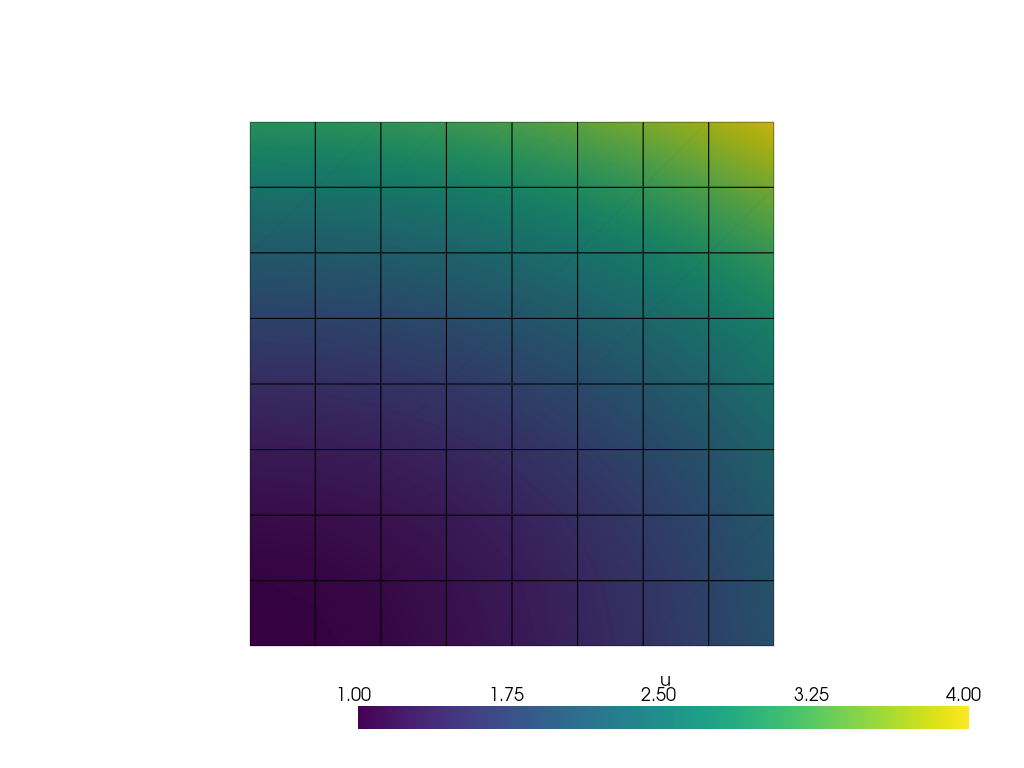

In [20]:
# I create a mesh with geometry based on the coordinates of the degrees of freedom of V
u_topology, u_cell_types, u_geometry = plot.vtk_mesh(V)

# I build an unstructured grid as done before
u_grid = pyvista.UnstructuredGrid(u_topology, u_cell_types, u_geometry)

u_grid.point_data["u"] = uh.x.array.real # Associates a scalar field (i.e., the values of uh) to the grid nodes
u_grid.set_active_scalars("u") # Sets 'u' as the active scalar! So it will color the mesh based on the values of u

# Now I plot
u_plotter = pyvista.Plotter()
u_plotter.add_mesh(u_grid, show_edges=True)
u_plotter.view_xy()
if not pyvista.OFF_SCREEN:
    u_plotter.show()

## Additional Plots

Other plots related to the Poisson problem.

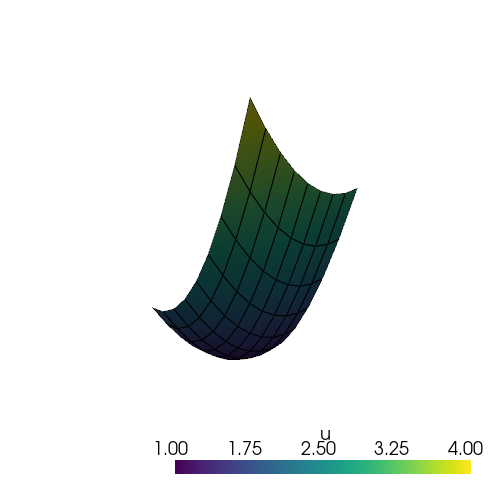

In [21]:
warped = u_grid.warp_by_scalar()
plotter2 = pyvista.Plotter(window_size=(500,500))
plotter2.add_mesh(warped, show_edges=True, show_scalar_bar=True)
if not pyvista.OFF_SCREEN:
    plotter2.show()